# NYC Taxis

There is a wealth of information available about taxi rides in New York City. We analysis it here to show the cool and powerful stuff we'll be doing in class!

I'm following some analysis from [Drew Levitt](https://www.ocf.berkeley.edu/~dlevitt/2015/12/13/final-project-nyc-taxi-and-uber-data/), and doing some of my own things.

In Python, we import packages to bring in functionality. At first, this can be a little annoying because you can only use core language functions without importing in more packages. However, you'll quickly see that this enables anyone to make new packages for Python and integrate the code very easily, and since people post their code online, we can access a huge range of already-written functionality.

We import many packages here to do a wide variety of analysis and presentation in this example.

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
import shapely.geometry as geometry
pd.set_option("display.max_rows", 5)  # limit number of rows shown in dataframe
# display plots within the notebook
%matplotlib inline
import seaborn as sns  # for better style in plots
import fiona
import cartopy.crs as ccrs  # if you install yourself using Anaconda, use 'conda install -c scitools cartopy'
import cartopy.feature as feature
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo  # if you install yourself using Anaconda, use 'conda install -c conda-forge cmocean'
from datetime import datetime

Here are some niceties for the fonts in our plots.

In [28]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['font.sans-serif'] = 'Arev Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.cal'] = 'cursive'
mpl.rcParams['mathtext.rm'] = 'sans'
mpl.rcParams['mathtext.tt'] = 'monospace'
mpl.rcParams['mathtext.it'] = 'sans:italic'
mpl.rcParams['mathtext.bf'] = 'sans:bold'
mpl.rcParams['mathtext.sf'] = 'sans'
mpl.rcParams['mathtext.fallback_to_cm'] = 'True'

Because the data files are quite large for this example, I previously did some work to cut them down in size. I have preserved my steps in the following cell. Then I saved the file to [figshare](https://figshare.com/) to share it with you.

In [29]:
# # May 2016 - too large! So I have previously limited it.
# url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv'
# loc = '../data/'  # relative path location
# os.system('wget --directory-prefix=' + loc + ' ' + url)  # this downloads the data

# # also decimated to use only every 10th row of data
# df = pd.read_csv(loc + 'yellow_tripdata_2016-05-01.csv', parse_dates=[1,2], index_col=[1], keep_date_col=True)
# df[::10].to_csv(loc + 'yellow_tripdata_2016-05-01_decimated.csv')

In [30]:
loc = '../data/'  # relative path location
fname = '5904615?private_link=8df0e7f96aa9cad2539d'
url = 'https://ndownloader.figshare.com/files/' + fname  # on figshare
# We won't re-download data files in the class server but will just share what is already there.
# so this is commented out:
# os.system('wget --directory-prefix=' + loc + ' ' + url)
# os.rename(loc + fname, loc + 'yellow_tripdata_2016-05-01_decimated.csv')

## 1D analysis

The package `pandas` is used for time series analysis, or anything that can easily be put into a sort of Excel format. The taxi data lends itself to being read in this way because each taxi ride is a separate row in the `csv` file. It also allows us to send in special arguments to the call which tell the code how to understand dates and times correctly, which can otherwise be difficult.

In [31]:
df = pd.read_csv('../data/yellow_tripdata_2016-05-01_decimated.csv', parse_dates=[0, 2], index_col=[0], keep_date_col=True)

We see that there are many columns of data in this file.

In [32]:
df

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,1,2016-05-01 00:17:00,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.5,0,0.3,17.8
2016-05-01 00:00:00,2,2016-05-01 00:00:00,2,18.41,-73.781059,40.645020,2,N,-73.984573,40.768398,2,52.0,0.0,0.5,0.0,0,0.3,52.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-01 23:59:00,1,2016-05-02 00:05:00,1,0.50,-73.984489,40.760044,1,N,-73.988449,40.764175,2,5.5,0.5,0.5,0.0,0,0.3,6.8
2016-05-01 23:59:00,2,2016-05-02 00:13:00,1,4.05,-73.989357,40.758759,1,N,-73.949982,40.805481,1,14.5,0.5,0.5,2.2,0,0.3,18.0


Let's examine the data, starting with a time series. Here we have the length of each trip throughout the day.

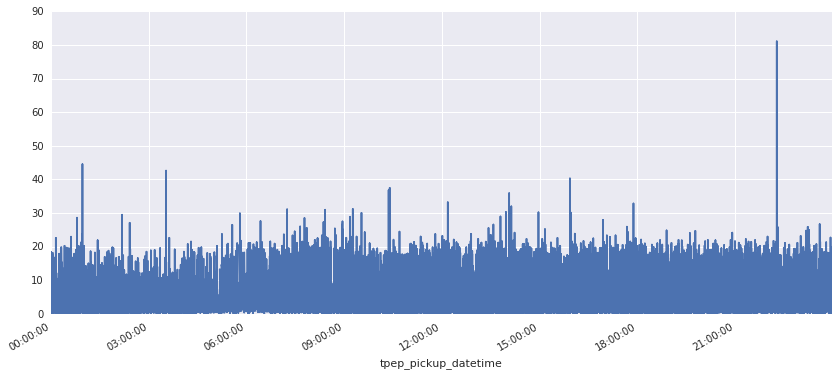

In [7]:
df['trip_distance'].plot(figsize=(14,6))

The data is too dense to interpret very well, but we can resample very easily.

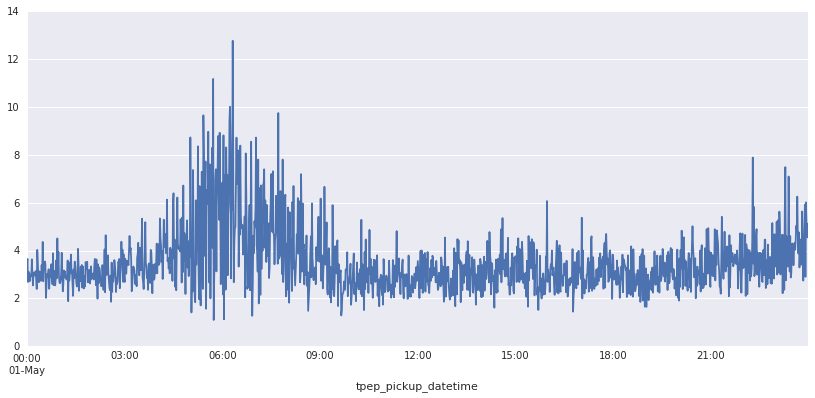

In [8]:
# resample to every 1 minute, taking the average of the nearby points
df['trip_distance'].resample('1T', 'mean').plot(figsize=(14,6))

Now we can see that there tend to be longer trips in the morning — maybe for commuting in? Or maybe more flights come in at that time of day, in a short period of time?

We see that the fare amount is visually correlated with the trip distance:

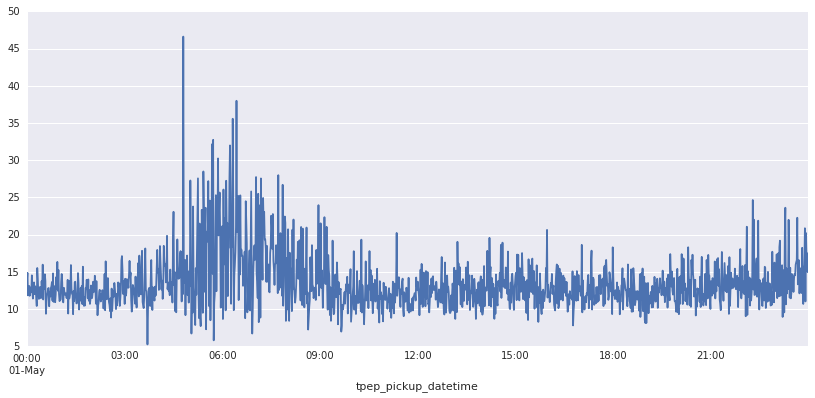

In [35]:
df['fare_amount'].resample('1T').plot(figsize=(14,6))

But how correlated are they? We can do some statistics using `pandas`, but let's try out `seaborn` since it is another great package and it's speciality is statistics.

With seaborn, which we have been using to make the defaults in our plots look nice already, we can easily look at the visual correlation between these two properties, calculate the pearson r coefficient, the p value, and look at the distribution of both variables:

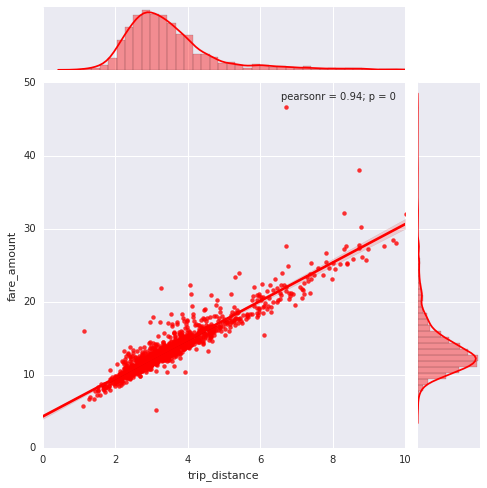

In [10]:
g = sns.jointplot("trip_distance", "fare_amount", data=df.resample('1T'), kind="reg",
                  xlim=(0, 10), ylim=(0, 50), color="r", size=7)

The two properties are, indeed, highly correlated.

## 2D analysis

Now let's look at the data spatially to learn more. Here we plot all of the pickup locations.

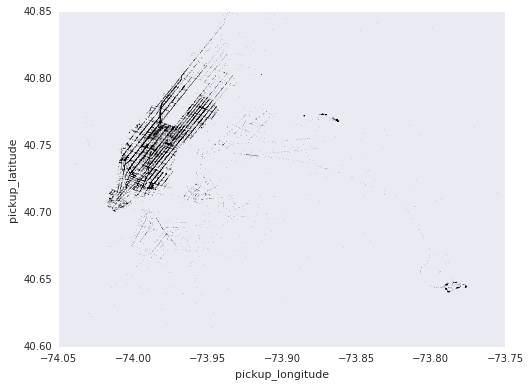

In [37]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.axis([-74.05, -73.75, 40.6, 40.85])  # NYC region
# ax.axis([-74.02, -73.92, 40.7, 40.85])  # Manhatten

df.plot.scatter(ax=ax, x='pickup_longitude', y='pickup_latitude', s=0.5, c='k', alpha=0.1, grid=False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)

We see the grid of Manhatten streets, as well as lighter outlying regions with fewer pickups, and a few distant pickup areas. What are the different regions?

Maybe it would be easier to look at the spatial patterns of taxi rides from a more aggregated perspective using NYC neighborhoods. To do this, we first download a file that contains polygons defining the edge of each neighborhood.

In [47]:
# NYC neighborhoods
fname_orig = '06463a12c2104adf86335df0170c25e3pediacitiesnycneighborhoods.geojson'
fname = 'nyc_neighborhoods.geojson'
url = 'http://catalog.civicdashboards.com/dataset/eea7c03e-9917-40b0-bba5-82e8e37d6739/resource/91778048-3c58-449c-a3f9-365ed203e914/download/'+ fname
loc = '../data/'  # relative path location
# don't actually download this – just use the existing copy
# os.system('wget --directory-prefix=' + loc + ' ' + url)  # download neighborhoods
# os.rename(loc + fname, loc + fname)

We read in each neighborhood as a separate polygon using the `shapely` and `fiona` packages, and store it in the `nyc` variable.

In [48]:
nyc = geometry.MultiPolygon([geometry.shape(pol['geometry']) for pol in fiona.open(loc + fname)])

What do these neighborhoods look like? We use the `cartopy` package here to show the neighborhoods nicely on a projected map, where we can also include the coastline (and other features if we wanted).

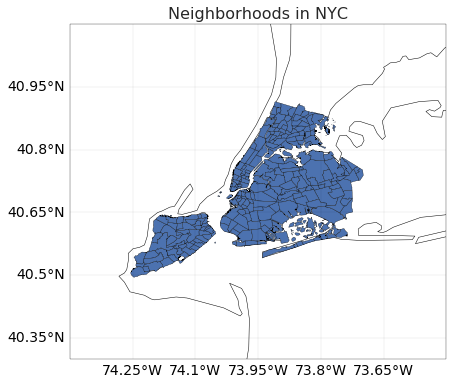

In [14]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-74.4, -73.5, 40.3, 41.1])
# http://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html?highlight=coastlines#cartopy.mpl.geoaxes.GeoAxes.coastlines
ax.coastlines(resolution='10m', linewidth=0.5)
ax.set_title('Neighborhoods in NYC', fontsize=16)
# labels and grid lines: http://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'k'}
gl.ylabel_style = {'size': 14, 'color': 'k'}

for polygon in nyc:
    ax.add_geometries([polygon], ccrs.PlateCarree())

Let's examine pickups and dropoffs by neighborhood. To do this, we need to count the number of each is inside each neighborhood. The `shapely` package allows us to do this.

In [15]:
# use every delta data point to save some time
delta = 20
# Define the pickups and dropffs as Points
pickups = geometry.MultiPoint(list(zip(df['pickup_longitude'][::delta], df['pickup_latitude'][::delta])))
dropoffs = geometry.MultiPoint(list(zip(df['dropoff_longitude'][::delta], df['dropoff_latitude'][::delta])))

# Use the Points to calculate pickup and dropff density
pickupdensity = np.zeros(len(nyc))
dropoffdensity = np.zeros(len(nyc))
for i, neighborhood in enumerate(nyc):
    pickupdensity[i] = np.asarray([neighborhood.contains(pickup) for pickup in pickups]).sum()/neighborhood.area
    dropoffdensity[i] = np.asarray([neighborhood.contains(dropoff) for dropoff in dropoffs]).sum()/neighborhood.area    

Now we can plot the results

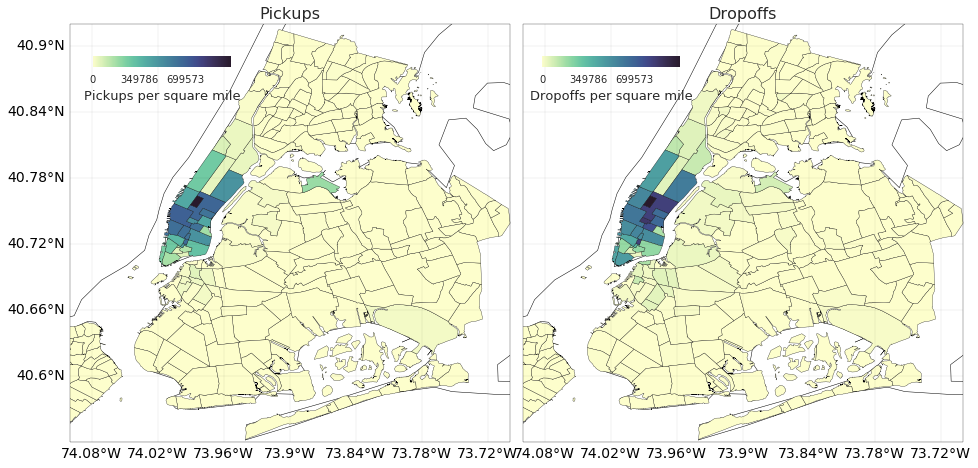

In [16]:
# Show pickups vs. dropoffs by neighborhood per square mile
cmap = cmo.deep

# Find max value ahead of time so colorbars are matching and accurate
vmax = max((dropoffdensity.max(), pickupdensity.max()))

fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(wspace=0.03)

# Pickups
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent([-74.1, -73.7, 40.54, 40.92])  # NYC region
ax.coastlines(resolution='10m', linewidth=0.5)
ax.set_title('Pickups', fontsize=16)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'k'}
gl.ylabel_style = {'size': 14, 'color': 'k'}

for pickup, neighborhood in zip(pickupdensity, nyc):
    color = cmap(pickup/pickupdensity.max())
    ax.add_geometries([neighborhood], ccrs.PlateCarree(), facecolor=color)

# Make colorbar: http://matplotlib.org/examples/api/colorbar_only.html
cax = fig.add_axes([0.145, 0.8, 0.12, 0.02])
norm = colors.Normalize(vmin=0, vmax=vmax)
cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Pickups per square mile', fontsize=13)
cb.set_ticks(np.arange(0, vmax, vmax/3))

# Dropoffs
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.set_extent([-74.1, -73.7, 40.54, 40.92])  # NYC region
ax.coastlines(resolution='10m', linewidth=0.5)
ax.set_title('Dropoffs', fontsize=16)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'k'}
gl.ylabel_style = {'size': 14, 'color': 'k'}

for dropoff, neighborhood in zip(dropoffdensity, nyc):
    color = cmap(dropoff/dropoffdensity.max())
    ax.add_geometries([neighborhood], ccrs.PlateCarree(), facecolor=color)

# Make colorbar: http://matplotlib.org/examples/api/colorbar_only.html
cax = fig.add_axes([0.535, 0.8, 0.12, 0.02])
norm = colors.Normalize(vmin=0, vmax=vmax)
cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Dropoffs per square mile', fontsize=13)
cb.set_ticks(np.arange(0, vmax, vmax/3))

We can see some differences in this maps, but it is a little hard to tell. Certainly there is more going on in the middle of downtown. Let's calculate a difference map instead.

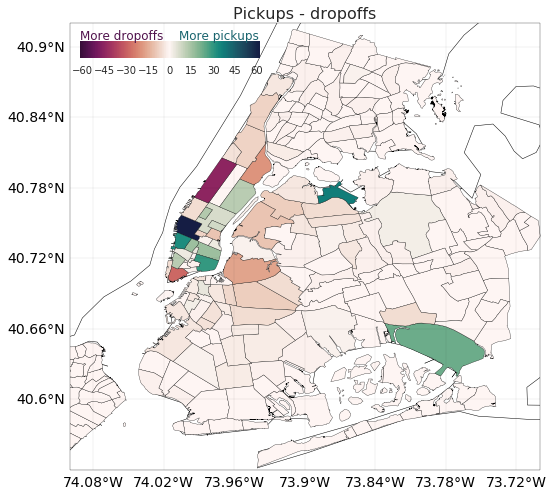

In [17]:
# Show pickups - dropoffs by neighborhood
cmap = cmo.curl_r  # colormap to use

# background of the plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-74.1, -73.7, 40.54, 40.92])  # NYC region
ax.coastlines(resolution='10m', linewidth=0.5)
ax.set_title('Pickups - dropoffs', fontsize=16)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'k'}
gl.ylabel_style = {'size': 14, 'color': 'k'}

# save the differences in pickups and dropoffs so the colorbar can be set correctly
diffs = [pickup*neighborhood.area - dropoff*neighborhood.area for pickup, dropoff, neighborhood in zip(pickupdensity, dropoffdensity, nyc)]
vmax = max(abs(np.asarray(diffs)))

# loop through to find the correct color for each amount of passengers
for diff, neighborhood in zip(diffs, nyc):
    color = cmap(diff/(2*vmax) + 0.5)  # shifts the number of passengers to be between 0 and 1, needed for the colormap
    geoms = ax.add_geometries([neighborhood], ccrs.PlateCarree(), facecolor=color) # add the neighborhood to the plot

# Make colorbar: http://matplotlib.org/examples/api/colorbar_only.html
cax = fig.add_axes([0.2, 0.84, 0.25, 0.03])
norm = colors.Normalize(vmin=-vmax, vmax=vmax)
cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cax.text(0.55, 1.1, 'More pickups', color='#18636D', transform=cax.transAxes, fontsize=12)
cax.text(0.0, 1.1, 'More dropoffs', color='#50124C', transform=cax.transAxes, fontsize=12)

Now we see that there are more pickups (greens) in certain regions, integrated throughout this particular day, and more dropoffs (reds) in other regions. Yet others cancel out to be about equal pickups and dropoffs.

But what is the pattern throughout the day? Maybe it changes? To see this, let's make a movie!

In [18]:
def calc(j, nyc):
    '''
    Calculate the differences in pickups and dropoffs for each neighborhood in nyc, for the first 
    5 minutes of the jth hour of the day.
    '''
    
    # get data for a chunk of time (5 min)
    start = '2016-05-01 ' + str(j).zfill(2) + ':00'
    stop = '2016-05-01 ' + str(j).zfill(2) + ':05'
    pickups = geometry.MultiPoint(list(zip(df[start:stop]['pickup_longitude'], df[start:stop]['pickup_latitude'])))
    dropoffs = geometry.MultiPoint(list(zip(df[start:stop]['dropoff_longitude'], df[start:stop]['dropoff_latitude'])))

    pickupdensity = np.zeros(len(nyc))
    dropoffdensity = np.zeros(len(nyc))
    for i, neighborhood in enumerate(nyc):
        pickupdensity[i] = np.asarray([neighborhood.contains(pickup) for pickup in pickups]).sum()/neighborhood.area
        dropoffdensity[i] = np.asarray([neighborhood.contains(dropoff) for dropoff in dropoffs]).sum()/neighborhood.area    
    
    diffs = [pickup*neighborhood.area - dropoff*neighborhood.area for pickup, dropoff, neighborhood in zip(pickupdensity, dropoffdensity, nyc)]

    return diffs

# save the differences in pickups and dropoffs so the colorbar can be set correctly
diffs = []
# Calculate for every other hour of the day
for j in range(1, 24, 2):
    diffs.append(calc(j, nyc))
vmax = max(0, abs(np.asarray(diffs)).max())

Now that we have calculated the differences, we can use similar code as before to plot up the difference in pickups and dropoffs throughout the day.

In [19]:
# where to store figures
figloc = 'figures/intro/'
if not os.path.exists(figloc):
    os.mkdir(figloc)

cmap = cmo.curl_r  # colormap to use

# set up the plot
fig = plt.figure(figsize=(10,8))
icount = 0

for j in range(1, 24, 2):
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-74.1, -73.7, 40.54, 40.92])  # NYC region
    # plot the background of each frame
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.set_title('Pickups - dropoffs', fontsize=16)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

    # Make colorbar: http://matplotlib.org/examples/api/colorbar_only.html
    cax = fig.add_axes([0.2, 0.84, 0.25, 0.03])
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    cax.text(0.55, 1.1, 'More pickups', color='#18636D', transform=cax.transAxes, fontsize=12)
    cax.text(0.0, 1.1, 'More dropoffs', color='#50124C', transform=cax.transAxes, fontsize=12)  

    # Write out the time of day
    ax.text(0.1, 0.82, datetime(2016, 5, 1, j).strftime('%-I%p'), transform=ax.transAxes)

    # loop through to find the correct color for each amount of passengers
    for diff, neighborhood in zip(diffs[icount], nyc):
        color = cmap(diff/(2*vmax) + 0.5)  # shifts the number of passengers to be between 0 and 1, needed for the colormap
        ax.add_geometries([neighborhood], ccrs.PlateCarree(), facecolor=color) # add the neighborhood to the plot
    icount += 1
    # don't save the figure since we can't write to a file 
#     fig.savefig(figloc + str(j).zfill(2) + '.png', bbox_inches='tight', dpi=72)
    fig.clear()

Now we can use the Linux program `ffmpeg` to link the images together as a movie.

In [20]:
# Don't actually do this since the figures are pre-saved.
# # First need to make it so the image files have an even number of pixels in each direction
# os.chdir(figloc)
# # This makes the figure have an even number of pixels. Only run this once.
# os.system("find . -iname '*.png' -maxdepth 1 -exec convert -gravity west -chop 1x0 {} {} \;")
# os.chdir('../..')

In [21]:
# Don't actually do this since the movie is already created beforehand
# if os.path.exists(figloc + 'movie.mp4'):
#     os.remove(figloc + 'movie.mp4')
# # Then use ffmpeg to make an animation from the frames
# os.system("ffmpeg -r 3 -pattern_type glob -i " + "'" + figloc + "'" "'/*.png' -c:v libx264 -pix_fmt yuv420p -crf 25 " + figloc + "/movie.mp4")

0

Now we have our animation and we can view it here! Note that this embedded video did not work in Safari, but it did work in Chrome.

In [40]:
from IPython.display import HTML
HTML("""
<video controls>
  <source src="figures/intro/movie.mp4" type="video/mp4">
</video>
""")